# Intro to Regression
We're going through a few regression exercises that will help you see how regression works in Python.

 

## Objectives: 
At the end of this notebook the students should:
- Be able to visualize data
- Look for correlations and multicollinearity
- Understand how linear regression models work
- Interpret basic regression statistics like R^2
- Do basic feature engineering and selection to improve models


Be able to create linear regression in:
- [***statsmodels***](http://statsmodels.sourceforge.net/): a package mainly best at doing regressions with traditional R formula syntax
- [***scikit-learn***](http://scikit-learn.org/dev/index.html): This is the main machine learning package we'll be using throughout the course.  It has a multitude of machine learning algorithms and helpful machine learning pipeline tools.  sklearn has a tremendous amount of functionality, to get the most out of this course it will help to really explore the depth of the documentation on your own and watch as you understand more and more of the functionality as the course progresses.


Gain familiarity with the following:
- ***R formulas***: R formulas are a convenient way for encapsulating functional relationships for regressions
- [***seaborn***](http://stanford.edu/~mwaskom/software/seaborn/): We'll use seaborn for **visualization** as we go along
- [***Variable Preprocessing and Polynomial Regression***](http://scikit-learn.org/dev/modules/preprocessing.html#preprocessing) with scikit-learn:  We'll be **"standardizing"** many of our variables to yield better model data.  We'll show how the "linear" models can be extended to basically any type of function by using functions of the different fields as the inputs to the linear model.

## Data
We'll take a look at: [Car price predictor dataset](https://www.kaggle.com/datasets/ananaymital/us-used-cars-dataset)

# Setup
Try running the following imports and check that they all import successfully.  If they do not, install commands are given below. If necessary, at a command line window use `pip` to install the ones that are failing for you and then retry the imports.

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline

## Installations (if necessary)

```` bash
conda install pandas numpy statsmodels seaborn scikit-learn
````

# Used Car Data
We will be working with US Used Car price data to demonstrate a few basic features of ***statsmodels*** and ***seaborn*** and how they might be used in a data science workflow for regression.

The dataset includes numerous predictive features we can use to predict Used car prices.

Let's load the dataset in using ***pandas*** and take a look at it.  Here we use [***pandas.read_table***](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_table.html) to load the data.

 <img src="./imgs/saab.png" />

In [2]:
import datetime as dt
pd.options.display.max_columns = 500

In [3]:
# Load data  
df=pd.read_csv('data/used_car_final.csv')
df.drop(df.filter(regex="Unname"),axis=1, inplace=True)

/var/folders/jn/625fnnbs1jg77y82ld96q65w0000gn/T/ipykernel_1396/509204982.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('data/used_car_final.csv')


In [4]:
df.columns

Index(['vin', 'back_legroom', 'bed', 'bed_height', 'bed_length', 'body_type',
       'cabin', 'city', 'city_fuel_economy', 'combine_fuel_economy',
       'daysonmarket', 'dealer_zip', 'description', 'engine_cylinders',
       'engine_displacement', 'engine_type', 'exterior_color', 'fleet',
       'frame_damaged', 'franchise_dealer', 'franchise_make', 'front_legroom',
       'fuel_tank_volume', 'fuel_type', 'has_accidents', 'height',
       'highway_fuel_economy', 'horsepower', 'interior_color', 'isCab',
       'is_certified', 'is_cpo', 'is_new', 'is_oemcpo', 'latitude', 'length',
       'listed_date', 'listing_color', 'listing_id', 'longitude',
       'main_picture_url', 'major_options', 'make_name', 'maximum_seating',
       'mileage', 'model_name', 'owner_count', 'power', 'price', 'salvage',
       'savings_amount', 'seller_rating', 'sp_id', 'sp_name', 'theft_title',
       'torque', 'transmission', 'transmission_display', 'trimId', 'trim_name',
       'vehicle_damage_category', 'whe

### 1 ) Drop object columns, 'id'  column (for now) 


In [5]:
## Let's start off by only using numerical vals 
num_cols=df.dtypes[df.dtypes!='object'].index
df_num=df[num_cols]

for i in df_num.columns:
    print(i)

city_fuel_economy
combine_fuel_economy
daysonmarket
engine_displacement
franchise_dealer
highway_fuel_economy
horsepower
is_certified
is_new
latitude
listing_id
longitude
mileage
owner_count
price
savings_amount
seller_rating
sp_id
vehicle_damage_category
year


In [6]:
#let's remove ids, combine_fuel_econ,is_certified, vehicle_damage  (all nulls)

no_ids=[c for c in df_num.columns if 'id' not in c and 'combine_fuel_economy' not in c and 'is_certified' not in c and 'vehicle_damage_category' not in c]

df_num=df_num[no_ids]
new_col_list=list(df_num.columns[-4:])
new_col_list.extend(df_num.columns[:-4])


In [7]:
# How many rows and columns does the dataset have?
df_num=df_num[new_col_list]

In [8]:
pd.set_option('display.max_columns', 500)

df_num.describe()

,price,savings_amount,seller_rating,year,city_fuel_economy,daysonmarket,engine_displacement,highway_fuel_economy,horsepower,latitude,longitude,mileage,owner_count
count,3.000000e+05,300000.000000,295962.000000,300000.000000,250785.000000,300000.000000,282832.000000,250785.000000,282832.000000,300000.000000,300000.000000,2.854900e+05,148566.000000
mean,2.986646e+04,550.710610,4.270607,2017.729140,22.715166,75.681377,2967.517113,29.490619,247.744332,36.979323,-90.661636,3.117954e+04,1.532881
std,1.936367e+04,1066.123926,0.512993,4.153011,8.799767,108.752689,1349.040620,7.764516,90.205560,4.991369,13.910306,4.550010e+04,0.924494
min,1.650000e+02,0.000000,1.000000,1921.000000,8.000000,0.000000,700.000000,10.000000,67.000000,18.398800,-157.913000,0.000000e+00,1.000000
25%,1.843700e+04,0.000000,4.000000,2017.000000,18.000000,14.000000,2000.000000,25.000000,175.000000,33.509200,-97.088200,6.000000e+00,1.000000
50%,2.639500e+04,0.000000,4.337838,2020.000000,21.000000,35.000000,2500.000000,29.000000,243.000000,37.819000,-87.256700,8.488500e+03,1.000000
75%,3.808700e+04,785.000000,4.600000,2020.000000,26.000000,82.000000,3600.000000,33.000000,300.000000,40.989400,-80.491600,4.371200e+04,2.000000
max,2.698500e+06,68745.000000,5.000000,2021.000000,127.000000,2976.000000,8400.000000,127.000000,808.000000,61.161800,-66.078500,1.111111e+06,19.000000


### Step #3 : Perform Initial EDA

### Without EDA we are .. 

<img src="./imgs/flying_blind.png" />


Remember that without conducting a proper EDA we are flying blind.   
Be curious about your data!    
What are the distributions? 

### Visualizing with Seaborn
We see that the data has 30 responses with 7 fields (6 independent, 1 dependent) each.  Let's use pandas to check out the correlations between the different variables.

In [9]:
# View the correlations
df_num.corr()

,price,savings_amount,seller_rating,year,city_fuel_economy,daysonmarket,engine_displacement,franchise_dealer,highway_fuel_economy,horsepower,is_new,latitude,longitude,mileage,owner_count
price,1.000000,-0.000193,0.067227,0.364728,-0.173225,0.059789,0.372268,0.286238,-0.249249,0.595370,0.381213,-0.024900,-0.027236,-0.451732,-0.226621
savings_amount,-0.000193,1.000000,0.011826,-0.191350,-0.100935,-0.079171,0.138119,-0.211124,-0.095005,0.159454,-0.506082,-0.007035,-0.009024,0.245934,-0.069055
seller_rating,0.067227,0.011826,1.000000,-0.047196,-0.038612,-0.003240,0.029683,-0.035837,-0.048969,0.061429,-0.037162,0.091023,0.004062,0.035209,0.007106
year,0.364728,-0.191350,-0.047196,1.000000,0.156650,-0.001715,-0.138952,0.496985,0.148096,0.029600,0.556909,-0.069760,-0.014329,-0.775094,-0.589457
city_fuel_economy,-0.173225,-0.100935,-0.038612,0.156650,1.000000,0.008001,-0.663650,0.059972,0.940621,-0.670623,0.100476,-0.039510,-0.084458,-0.151304,-0.128683
daysonmarket,0.059789,-0.079171,-0.003240,-0.001715,0.008001,1.000000,-0.046184,0.003822,-0.000570,-0.022551,0.173767,0.020969,0.012853,-0.084025,0.098130
engine_displacement,0.372268,0.138119,0.029683,-0.138952,-0.663650,-0.046184,1.000000,-0.061636,-0.692463,0.831013,-0.067474,-0.005277,-0.008209,0.150948,0.120162
franchise_dealer,0.286238,-0.211124,-0.035837,0.496985,0.059972,0.003822,-0.061636,1.000000,0.044336,0.025107,0.470942,0.003177,0.015790,-0.520205,-0.268097
highway_fuel_economy,-0.249249,-0.095005,-0.048969,0.148096,0.940621,-0.000570,-0.692463,0.044336,1.000000,-0.703154,0.058826,-0.062394,-0.080845,-0.138864,-0.127824
horsepower,0.595370,0.159454,0.061429,0.029600,-0.670623,-0.022551,0.831013,0.025107,-0.703154,1.000000,0.008277,-0.012761,-0.012199,-0.014722,0.000477


#### Correlation Map

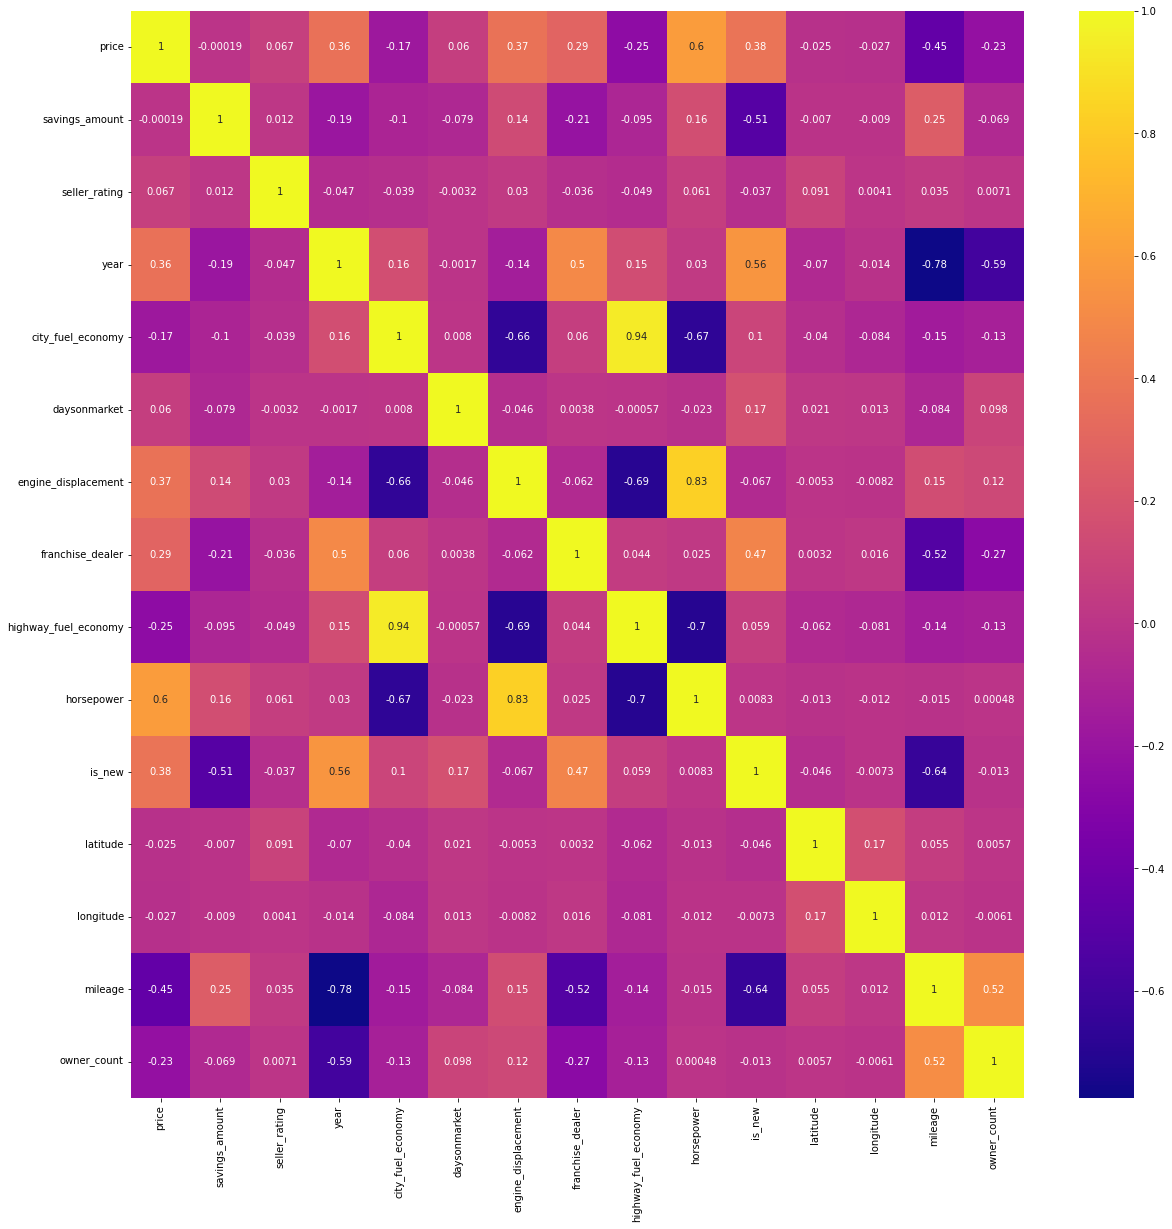

In [10]:
# example of a better corr matrix
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(df_num.corr(), cmap="plasma", annot=True, ax=ax);
# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

### Correlation and Multicollinearity
We notice that some of the variables are highly correlated.  This is something we might want to take into consideration later.  When 2 predictor variables are highly correlated this is called [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity) and it is something we want to watch out for as it can destabilize our model.  In the extreme case, when 2 predictors are perfectly correlated then there is absolutely nothing gained by making both variables part of our regression.

The other takeaway from this table is that some of our predictors are highly correlated with our ***target variable Y***.  This is a good thing, it means that these are the variables that we most likely want to include as part of our model as they explain a large amount of the variance in the target variable (correlation=R, variance_explained=R<sup>2</sup>).

Let's try to visualize these correlations all together by using the [***seaborn pairplot***](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.pairplot.html) function.

> What do you notice?

> Almost all correlations are positive, somewhat normal distributions, etc.

In [11]:
df_num.corr().iloc[0]

price                   1.000000
savings_amount         -0.000193
seller_rating           0.067227
year                    0.364728
city_fuel_economy      -0.173225
daysonmarket            0.059789
engine_displacement     0.372268
franchise_dealer        0.286238
highway_fuel_economy   -0.249249
horsepower              0.595370
is_new                  0.381213
latitude               -0.024900
longitude              -0.027236
mileage                -0.451732
owner_count            -0.226621
Name: price, dtype: float64

In [12]:
df_num.corr().iloc[0][np.argsort(np.abs(df_num.corr().iloc[0]))]

savings_amount         -0.000193
latitude               -0.024900
longitude              -0.027236
daysonmarket            0.059789
seller_rating           0.067227
city_fuel_economy      -0.173225
owner_count            -0.226621
highway_fuel_economy   -0.249249
franchise_dealer        0.286238
year                    0.364728
engine_displacement     0.372268
is_new                  0.381213
mileage                -0.451732
horsepower              0.595370
price                   1.000000
Name: price, dtype: float64

### Pairplot Map

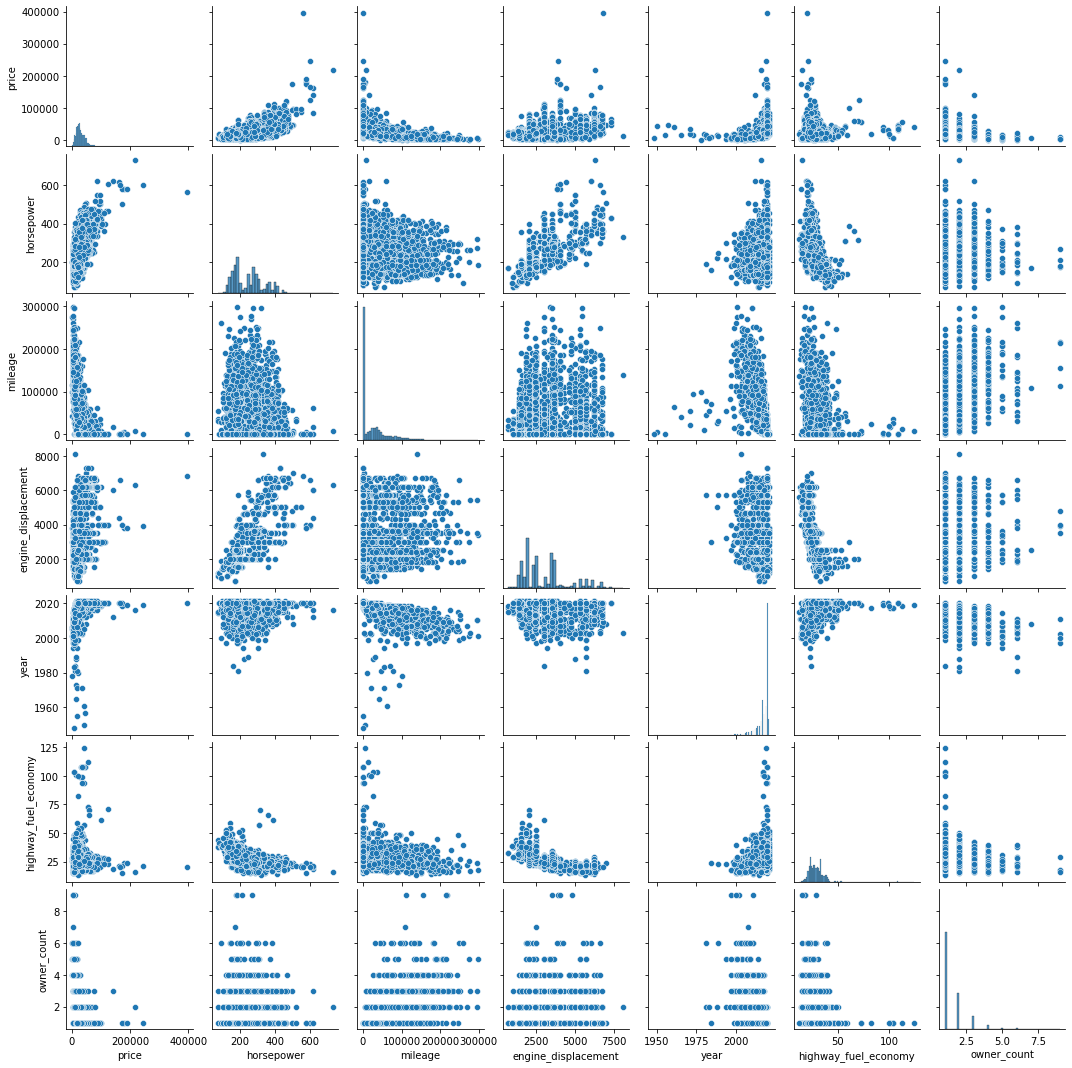

In [13]:
# OPEN : color? 
my_palette=sns.color_palette('flare')
df_samp=df_num[['price','horsepower','mileage','engine_displacement','year','highway_fuel_economy','owner_count']].sample(5000)
g=sns.pairplot(df_samp,kind="scatter",palette=my_palette);
g.fig.set_size_inches(15,15)

### Ordinary Least Squares Regression with Statsmodels
Now that we have a feel for our data, let's jump right in and try a basic regression model.  

#### Statsmodels
We are going to use the [**`statsmodels`**](http://statsmodels.sourceforge.net/) library first.  `statsmodels` is a Python package for implementing [**linear models**](https://en.wikipedia.org/wiki/Linear_model), of which **Linear Regression** is one.  It has a bunch of nice features for evaluating and executing such models.  Essentially, a linear model is one that is a **linear function of the parameters**.  For Linear Regression, this means the parameter $\beta$ (note that here $\beta$ is a **vector** of parameters, which includes $\beta_0$, $\beta_1$, $\beta_2$, etc).  We'll discuss linear models generally later but for  now just accept that Linear Regression is one of these.

#### Modeling with Statsmodels
There are 2 main ways you can generate models with stats models:
- Via the `statsmodels.api` package
- Via the `statsmodels.formula.api` package

For both approaches, you'll need somewhere to use the R formula style formulas for defining the relationship between target variable and feature variables in your model.  ***Statsmodels*** uses [***patsy***](http://patsy.readthedocs.org/en/latest/) to convert this syntax into the proper data matrices for input into its linear models under the covers.  There are a variety of interactions and functions of variables that you can incorporate with this syntax, so feel free to check out the docs.

Here we'll just start by defining a regression model that takes as its inputs each of the *14* predictor variables.  The other parameter of course is the data that the model is to be built from, our pandas dataframe.

This first model fitting is done for you, it fits a multiple linear regression model of the following form (notice the use of [MathJax](https://www.mathjax.org/) for rendering such lovely math equations in markdown):

$$
\widehat{Y} = \beta_0 + \beta_1X_1 + \beta_2X_2 + \beta_3X_3 + \beta_4X_4 + \beta_5X_5 + \beta_6X_6 +\beta_7X_7 + \beta_8X_8 + \beta_9X_9 + \beta_10X_{10} + \beta_11X_{11} + \beta_12X_{12} + \beta_13X_{13}
$$

##### `statsmodels.api`
To use this method, you need to generate a **matrix** of **features**, **`X`** and a **vector** of **targets**, **`y`** where each row represents a single **observation**.  In statsmodels, you can do this with a call to **`patsy.dmatrices`**:


In [14]:
df_num.price.describe()

count    3.000000e+05
mean     2.986646e+04
std      1.936367e+04
min      1.650000e+02
25%      1.843700e+04
50%      2.639500e+04
75%      3.808700e+04
max      2.698500e+06
Name: price, dtype: float64

### Step 4) Let's Build the 1st Model (Baseline Model) , 

In [15]:
# Create your feature matrix (X) and target vector (y)

y, X = patsy.dmatrices('price~city_fuel_economy+daysonmarket+engine_displacement+franchise_dealer+highway_fuel_economy+horsepower+is_new+latitude+longitude+mileage+owner_count+savings_amount+seller_rating', data=df_num)
# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     7204.
Date:                Sat, 11 Jun 2022   Prob (F-statistic):               0.00
Time:                        08:13:46   Log-Likelihood:            -1.3274e+06
No. Observations:              121854   AIC:                         2.655e+06
Df Residuals:                  121840   BIC:                         2.655e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 1792.5066    665.303      2.694      0.007     488.523    3096.490
franchise_dealer[T.True]  1422.5039     83.647     17.006      0.000    1258.558    1586.450
is_new[T.True]            1.123e+04   1433.694      7.833      0.000    8419.755     1.4e+04
city_fuel_economy          618.5920     15.639     39.554      0.000     587.939     649.245
daysonmarket                -1.0722      0.402     -2.669      0.008      -1.860      -0.285
engine_displacement         -2.0830      0.063    -32.943      0.000      -2.207      -1.959
highway_fuel_economy      -567.1229     15.792    -35.911      0.000    -598.075    -536.170
horsepower                 116.6359      0.881    132.349      0.000     114.909     118.363
latitude                   -14.9564      7.803     -1.917      0.055     -30.251       0.338
longitude                   -9.5854      2.716     -3.529      0.000     -14.908      -4.262
mileage                     -0.1189      0.001   -111.900      0.000      -0.121      -0.117
owner_count               -403.3655     50.911     -7.923      0.000    -503.150    -303.581
savings_amount               2.2637      0.034     66.713      0.000       2.197       2.330
seller_rating             1114.1723     72.797     15.305      0.000     971.492    1256.853
==============================================================================
Omnibus:                   475364.997   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    1422383146200.289
Skew:                          94.161   Prob(JB):                         0.00
Kurtosis:                   16739.573   Cond. No.                     2.77e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.77e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### `statsmodels.formula.api`
The formula approach handles the creation of the `X` and `y` matrices internally, so all you have to do is supply the R formula for your model when you create your `ols` object.  

**NOTE:** We'll use this for the remainder of these exercises, but many people like to stick with the `dmatrices` and `X`, `y` matrix creation approach because that is the way `sklearn` works (see later).  Notice that here we've built the same model and it's deterministic, so the results are the same.

[Nonrobust vs. robust regression](https://en.wikipedia.org/wiki/Robust_regression#Methods_for_robust_regression)

In [16]:
# Define the model
lm1 = smf.ols('price~city_fuel_economy+daysonmarket+engine_displacement+franchise_dealer+highway_fuel_economy+horsepower+is_new+latitude+longitude+mileage+owner_count+savings_amount+seller_rating', data=df_num)
# Fit the model
fit1 = lm1.fit()

# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     7204.
Date:                Sat, 11 Jun 2022   Prob (F-statistic):               0.00
Time:                        08:13:47   Log-Likelihood:            -1.3274e+06
No. Observations:              121854   AIC:                         2.655e+06
Df Residuals:                  121840   BIC:                         2.655e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 1792.5066    665.303      2.694      0.007     488.523    3096.490
franchise_dealer[T.True]  1422.5039     83.647     17.006      0.000    1258.558    1586.450
is_new[T.True]            1.123e+04   1433.694      7.833      0.000    8419.755     1.4e+04
city_fuel_economy          618.5920     15.639     39.554      0.000     587.939     649.245
daysonmarket                -1.0722      0.402     -2.669      0.008      -1.860      -0.285
engine_displacement         -2.0830      0.063    -32.943      0.000      -2.207      -1.959
highway_fuel_economy      -567.1229     15.792    -35.911      0.000    -598.075    -536.170
horsepower                 116.6359      0.881    132.349      0.000     114.909     118.363
latitude                   -14.9564      7.803     -1.917      0.055     -30.251       0.338
longitude                   -9.5854      2.716     -3.529      0.000     -14.908      -4.262
mileage                     -0.1189      0.001   -111.900      0.000      -0.121      -0.117
owner_count               -403.3655     50.911     -7.923      0.000    -503.150    -303.581
savings_amount               2.2637      0.034     66.713      0.000       2.197       2.330
seller_rating             1114.1723     72.797     15.305      0.000     971.492    1256.853
==============================================================================
Omnibus:                   475364.997   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    1422383146200.289
Skew:                          94.161   Prob(JB):                         0.00
Kurtosis:                   16739.573   Cond. No.                     2.77e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.77e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Regression Statistics
From this we get a handful of useful statistics describing our regression. A google search on statistics should yield details for those interested, and we will cover them in depth soon. We will focus on the ***R<sup>2</sup>*** values and the middle table here.

***R<sup>2</sup>***  represents the estimated percentage of the variance in our target variable ***Y*** that can be explained by our regression model.  

$$R^2 = 1- (SSE/SST) $$ 

Where: 
$$ SSE= \sum_{s=i}(y_i-\hat{y}_i)^2$$ 

$$ SST= \sum_{s=i}(y_i-\bar{y})^2$$ 


***Adjusted R<sup>2</sup>*** also penalizes for things such as large coefficients and extra variables to try and limit ***overfitting*** so it is often a better measure of model efficacy. We will use that here.

The middle table provides the **coefficients** that are regression has found, along with the **standard error** for each coefficient. This defines our model, aka these are the model parameters that our algorithm was seeking to determine.  

The **t-scores** are values that the coefficients score in the [Student's T Distribution](https://en.wikipedia.org/wiki/Student's_t-distribution) and the **P>|t|** field represents the probability of finding such a t-score if the actual value of the coefficient were 0. In other words, if we had a coefficient whose true value should be 0 (aka the predictor has no impact on the response) then this P-value is the probability of finding such a coefficient value in our regression by random chance. In essence, it measures our degree of belief that the coefficient for each variable should be zero. Thus, the lowest P-values represent the most likely predictors to be impacting the response.

In [17]:

y, X = patsy.dmatrices('price~horsepower', data=df_num)
# Create your model
lm0 = sm.OLS(y, X)


# Fit the model
fit0 = lm0.fit()
# Print summary statistics of the model's performance
fit0.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                 1.553e+05
Date:                Sat, 11 Jun 2022   Prob (F-statistic):               0.00
Time:                        08:13:47   Log-Likelihood:            -3.1255e+06
No. Observations:              282832   AIC:                         6.251e+06
Df Residuals:                  282830   BIC:                         6.251e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1510.3333     83.776    -18.028      0.000   -1674.531   -1346.135
horsepower   125.2192      0.318    394.085      0.000     124.596     125.842
==============================================================================
Omnibus:                   714554.714   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     171938327433.733
Skew:                          26.926   Prob(JB):                         0.00
Kurtosis:                    3822.307   Cond. No.                         771.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

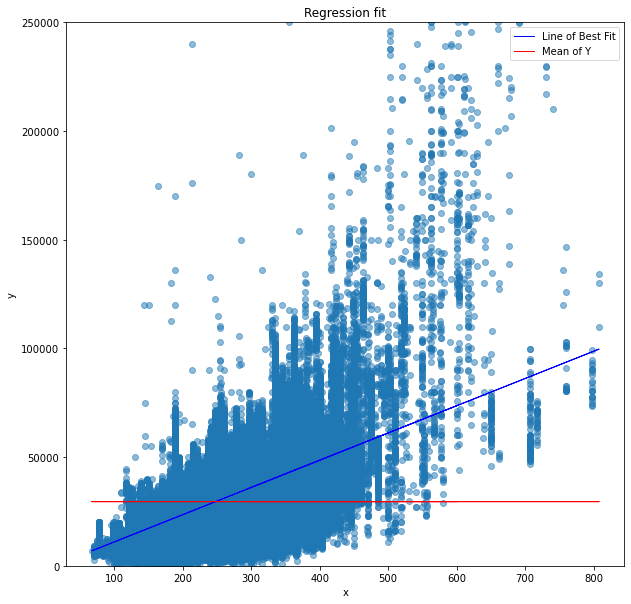

In [18]:

pred=fit0.predict()

plt.figure(figsize=(10,10))
plt.scatter(X[:,1],y,alpha=.5)
plt.plot(X[:,1], pred, color='blue',linewidth=1,label='Line of Best Fit')
plt.title("Regression fit")
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(0,250000)

y_bar=np.ones(len(y))*np.mean(y)
plt.plot(X[:,1], y_bar, color='red',linewidth=1,label='Mean of Y');
plt.legend();

[What is a baseline model?](https://datascience.stackexchange.com/questions/30912/what-does-baseline-mean-in-the-context-of-machine-learning)

### Step 5) Impute missing values

In [19]:
df_num=df_num.join(df[['model_name','make_name','engine_type','dealer_zip']])

In [20]:
df_num.describe()

,price,savings_amount,seller_rating,year,city_fuel_economy,daysonmarket,engine_displacement,highway_fuel_economy,horsepower,latitude,longitude,mileage,owner_count
count,3.000000e+05,300000.000000,295962.000000,300000.000000,250785.000000,300000.000000,282832.000000,250785.000000,282832.000000,300000.000000,300000.000000,2.854900e+05,148566.000000
mean,2.986646e+04,550.710610,4.270607,2017.729140,22.715166,75.681377,2967.517113,29.490619,247.744332,36.979323,-90.661636,3.117954e+04,1.532881
std,1.936367e+04,1066.123926,0.512993,4.153011,8.799767,108.752689,1349.040620,7.764516,90.205560,4.991369,13.910306,4.550010e+04,0.924494
min,1.650000e+02,0.000000,1.000000,1921.000000,8.000000,0.000000,700.000000,10.000000,67.000000,18.398800,-157.913000,0.000000e+00,1.000000
25%,1.843700e+04,0.000000,4.000000,2017.000000,18.000000,14.000000,2000.000000,25.000000,175.000000,33.509200,-97.088200,6.000000e+00,1.000000
50%,2.639500e+04,0.000000,4.337838,2020.000000,21.000000,35.000000,2500.000000,29.000000,243.000000,37.819000,-87.256700,8.488500e+03,1.000000
75%,3.808700e+04,785.000000,4.600000,2020.000000,26.000000,82.000000,3600.000000,33.000000,300.000000,40.989400,-80.491600,4.371200e+04,2.000000
max,2.698500e+06,68745.000000,5.000000,2021.000000,127.000000,2976.000000,8400.000000,127.000000,808.000000,61.161800,-66.078500,1.111111e+06,19.000000


In [21]:
df_impute=df_num.copy()
df_impute['owner_count']=df_impute['owner_count'].fillna(df_impute['owner_count'].mean())
df_impute.describe()

,price,savings_amount,seller_rating,year,city_fuel_economy,daysonmarket,engine_displacement,highway_fuel_economy,horsepower,latitude,longitude,mileage,owner_count
count,3.000000e+05,300000.000000,295962.000000,300000.000000,250785.000000,300000.000000,282832.000000,250785.000000,282832.000000,300000.000000,300000.000000,2.854900e+05,300000.000000
mean,2.986646e+04,550.710610,4.270607,2017.729140,22.715166,75.681377,2967.517113,29.490619,247.744332,36.979323,-90.661636,3.117954e+04,1.532881
std,1.936367e+04,1066.123926,0.512993,4.153011,8.799767,108.752689,1349.040620,7.764516,90.205560,4.991369,13.910306,4.550010e+04,0.650583
min,1.650000e+02,0.000000,1.000000,1921.000000,8.000000,0.000000,700.000000,10.000000,67.000000,18.398800,-157.913000,0.000000e+00,1.000000
25%,1.843700e+04,0.000000,4.000000,2017.000000,18.000000,14.000000,2000.000000,25.000000,175.000000,33.509200,-97.088200,6.000000e+00,1.000000
50%,2.639500e+04,0.000000,4.337838,2020.000000,21.000000,35.000000,2500.000000,29.000000,243.000000,37.819000,-87.256700,8.488500e+03,1.532881
75%,3.808700e+04,785.000000,4.600000,2020.000000,26.000000,82.000000,3600.000000,33.000000,300.000000,40.989400,-80.491600,4.371200e+04,1.532881
max,2.698500e+06,68745.000000,5.000000,2021.000000,127.000000,2976.000000,8400.000000,127.000000,808.000000,61.161800,-66.078500,1.111111e+06,19.000000


In [22]:
# .575 for imputation of owner count
lm2 = smf.ols('price~city_fuel_economy+daysonmarket+engine_displacement+franchise_dealer+highway_fuel_economy+horsepower+is_new+latitude+longitude+mileage+owner_count+savings_amount+seller_rating', data=df_impute)

# Fit the model
fit2 = lm2.fit()

# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                 2.438e+04
Date:                Sat, 11 Jun 2022   Prob (F-statistic):               0.00
Time:                        08:13:49   Log-Likelihood:            -2.5285e+06
No. Observations:              233787   AIC:                         5.057e+06
Df Residuals:                  233773   BIC:                         5.057e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -7351.4327    443.346    -16.582      0.000   -8220.378   -6482.487
franchise_dealer[T.True]  1380.0669     75.946     18.172      0.000    1231.215    1528.918
is_new[T.True]            7978.8977     82.985     96.149      0.000    7816.250    8141.545
city_fuel_economy          557.9099      9.775     57.073      0.000     538.750     577.069
daysonmarket                 1.9598      0.243      8.081      0.000       1.484       2.435
engine_displacement         -3.0963      0.040    -77.488      0.000      -3.175      -3.018
highway_fuel_economy      -533.4266     10.478    -50.909      0.000    -553.963    -512.890
horsepower                 153.8840      0.571    269.347      0.000     152.764     155.004
latitude                    23.0169      5.156      4.464      0.000      12.912      33.122
longitude                  -14.6250      1.824     -8.019      0.000     -18.200     -11.050
mileage                     -0.1155      0.001   -122.866      0.000      -0.117      -0.114
owner_count               -460.8289     46.633     -9.882      0.000    -552.229    -369.429
savings_amount               1.8529      0.030     62.640      0.000       1.795       1.911
seller_rating             1537.4799     49.027     31.360      0.000    1441.388    1633.572
==============================================================================
Omnibus:                   805370.505   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    1385037855677.787
Skew:                          64.074   Prob(JB):                         0.00
Kurtosis:                   11926.429   Cond. No.                     9.33e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Exercise

What other features could benefit from imputation of missing values? 

* Impute predictive feature values & confirm performance improvement on an iterative basis.
   Only if R^2 reflects improvement (or stays the same) , should the imputed version be retained

**Challenge** : create a function for imputation.  Perform imputation & performance improvement confirmation via a loop 

In [23]:
df_impute['horsepower']=df_impute[["horsepower","model_name","engine_type"]].groupby(["model_name","engine_type"]).transform(lambda x: x.fillna(x.median()))


# Define the model
lm2 = smf.ols('price~city_fuel_economy+daysonmarket+engine_displacement+franchise_dealer+highway_fuel_economy+horsepower+is_new+latitude+longitude+mileage+owner_count+savings_amount+seller_rating', data=df_impute)

# Fit the model
fit2 = lm2.fit()

# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                 2.438e+04
Date:                Sat, 11 Jun 2022   Prob (F-statistic):               0.00
Time:                        08:13:50   Log-Likelihood:            -2.5284e+06
No. Observations:              233781   AIC:                         5.057e+06
Df Residuals:                  233767   BIC:                         5.057e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -7353.2036    443.358    -16.585      0.000   -8222.173   -6484.234
franchise_dealer[T.True]  1380.1479     75.948     18.172      0.000    1231.292    1529.004
is_new[T.True]            7978.5454     82.989     96.140      0.000    7815.889    8141.202
city_fuel_economy          557.8962      9.776     57.070      0.000     538.736     577.056
daysonmarket                 1.9598      0.243      8.080      0.000       1.484       2.435
engine_displacement         -3.0964      0.040    -77.489      0.000      -3.175      -3.018
highway_fuel_economy      -533.4103     10.478    -50.905      0.000    -553.948    -512.873
horsepower                 153.8851      0.571    269.343      0.000     152.765     155.005
latitude                    23.0243      5.156      4.466      0.000      12.919      33.129
longitude                  -14.6278      1.824     -8.020      0.000     -18.203     -11.053
mileage                     -0.1155      0.001   -122.860      0.000      -0.117      -0.114
owner_count               -460.6743     46.635     -9.878      0.000    -552.078    -369.271
savings_amount               1.8529      0.030     62.638      0.000       1.795       1.911
seller_rating             1537.7643     49.029     31.365      0.000    1441.669    1633.859
==============================================================================
Omnibus:                   805348.277   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    1384959238564.708
Skew:                          64.074   Prob(JB):                         0.00
Kurtosis:                   11926.244   Cond. No.                     9.33e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
def impute_n_check(df,column):
    if column=='mileage':
        df[column]=df[[column,"dealer_zip","year"]].groupby(["dealer_zip","year"]).transform(lambda x: x.fillna(x.median()))
    else:
        df[column]=df[[column,"model_name","engine_type"]].groupby(["model_name","engine_type"]).transform(lambda x: x.fillna(x.median()))
    model = smf.ols('price~city_fuel_economy+daysonmarket+engine_displacement+franchise_dealer+highway_fuel_economy+horsepower+is_new+latitude+longitude+mileage+owner_count+savings_amount+seller_rating', data=df_impute)
    fit = model.fit()
    print(fit.rsquared)
    print('\n')
    return df,fit.rsquared
   

In [25]:
# warning : about 2 mins to 
cols_to_impute=['horsepower','city_fuel_economy','engine_displacement','mileage','highway_fuel_economy',]


for col in cols_to_impute:
    print(col)
    #print(impute_n_check(df_impute,col)[1])
    # update the imputed dataframe 
    df_impute=impute_n_check(df_impute,col)[0]
    
    

horsepower
0.5754668402785552


city_fuel_economy
0.5754668402785552


engine_displacement
0.5758451232095453


mileage
0.5782856758913132


highway_fuel_economy
0.5849039139676724




In [26]:
# Capture the latest with a new fit! 
lm3 = smf.ols('price~city_fuel_economy+daysonmarket+engine_displacement+franchise_dealer+highway_fuel_economy+horsepower+is_new+latitude+longitude+mileage+owner_count+savings_amount+seller_rating', data=df_impute)

# Fit the model
fit3 = lm3.fit()

# Print summary statistics of the model's performance
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                 2.997e+04
Date:                Sat, 11 Jun 2022   Prob (F-statistic):               0.00
Time:                        08:14:14   Log-Likelihood:            -2.9898e+06
No. Observations:              276537   AIC:                         5.980e+06
Df Residuals:                  276523   BIC:                         5.980e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -8468.0696    401.008    -21.117      0.000   -9254.033   -7682.106
franchise_dealer[T.True]  1508.5056     70.661     21.348      0.000    1370.011    1647.000
is_new[T.True]            7632.4593     75.411    101.211      0.000    7484.655    7780.263
city_fuel_economy          558.5093      8.951     62.396      0.000     540.966     576.053
daysonmarket                 2.7414      0.220     12.455      0.000       2.310       3.173
engine_displacement         -3.4843      0.036    -97.519      0.000      -3.554      -3.414
highway_fuel_economy      -521.0257      9.500    -54.845      0.000    -539.645    -502.406
horsepower                 159.8292      0.514    310.929      0.000     158.822     160.837
latitude                    26.3141      4.703      5.595      0.000      17.096      35.532
longitude                  -15.3889      1.677     -9.177      0.000     -18.676     -12.102
mileage                     -0.1160      0.001   -137.277      0.000      -0.118      -0.114
owner_count               -337.1914     41.945     -8.039      0.000    -419.402    -254.980
savings_amount               1.8487      0.027     69.545      0.000       1.797       1.901
seller_rating             1561.6428     44.877     34.798      0.000    1473.684    1649.601
==============================================================================
Omnibus:                   909436.626   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    1212445063435.695
Skew:                          55.812   Prob(JB):                         0.00
Kurtosis:                   10260.330   Cond. No.                     9.31e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.31e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
### Observe that we increased the number of observations we can model on from 121854 to 276537

### More data ~ Better,  why ?? 



### Plotting Residuals
Before we call it a day with this model and dataset, let's take a quick look at a plot of our residuals *(actual value - predicted value)* with this model.  We do this because in a good model we essentially want our errors to be random.  If our residuals look systematic (e.g. missing high for one range and low for another) then we probably are missing the actual functional dependency underlying the data (perhaps it's not really linear).

Take a look [here](http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit) for an example of a bad residual plot.

In [28]:
df_impute.describe()

,price,savings_amount,seller_rating,year,city_fuel_economy,daysonmarket,engine_displacement,highway_fuel_economy,horsepower,latitude,longitude,mileage,owner_count
count,3.000000e+05,300000.000000,295962.000000,300000.000000,282046.000000,300000.000000,289950.000000,282046.000000,289950.000000,300000.000000,300000.000000,2.979470e+05,300000.000000
mean,2.986646e+04,550.710610,4.270607,2017.729140,22.213104,75.681377,2963.694085,29.028779,247.883340,36.979323,-90.661636,3.002683e+04,1.532881
std,1.936367e+04,1066.123926,0.512993,4.153011,6.495145,108.752689,1337.905325,6.404917,90.022365,4.991369,13.910306,4.499721e+04,0.650583
min,1.650000e+02,0.000000,1.000000,1921.000000,8.000000,0.000000,700.000000,10.000000,67.000000,18.398800,-157.913000,0.000000e+00,1.000000
25%,1.843700e+04,0.000000,4.000000,2017.000000,18.000000,14.000000,2000.000000,24.000000,175.000000,33.509200,-97.088200,6.000000e+00,1.000000
50%,2.639500e+04,0.000000,4.337838,2020.000000,21.000000,35.000000,2500.000000,28.000000,245.000000,37.819000,-87.256700,4.939000e+03,1.532881
75%,3.808700e+04,785.000000,4.600000,2020.000000,26.000000,82.000000,3600.000000,33.000000,300.000000,40.989400,-80.491600,4.195700e+04,1.532881
max,2.698500e+06,68745.000000,5.000000,2021.000000,107.000000,2976.000000,8400.000000,93.000000,808.000000,61.161800,-66.078500,1.111111e+06,19.000000


In [29]:
from scipy import stats
def diagnostic_plot(x,y,model):
    plt.figure(figsize=(12,6))
    
    try:
        pred=model.predict()
        res=model.resid
    except: 
        pred=model.predict(X)
        res=y-pred
        

    plt.subplot(1, 2, 1)
    res = y - pred
    plt.scatter(pred, res,alpha=.5)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 2, 2)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm")
    plt.title("Normal Q-Q plot")

In [30]:
# still some prep .. 
df_impute.drop(['model_name','make_name','engine_type','dealer_zip'],axis=1,inplace=True)
df_impute=df_impute.dropna()

/var/folders/jn/625fnnbs1jg77y82ld96q65w0000gn/T/ipykernel_1396/2727729209.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=df_impute.drop('price',1)


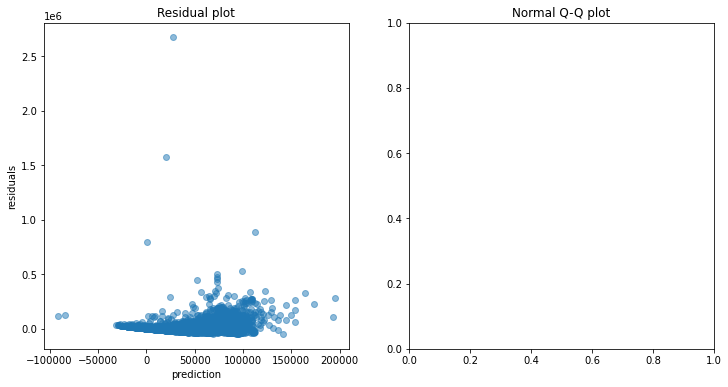

In [31]:
y=df_impute.price
X=df_impute.drop('price',1)
diagnostic_plot(X,y,fit3)

In [32]:
### OPEN: move this down 

### Remove significant outliers : 

res=fit3.resid

df_impute.iloc[np.argsort(res)[-4:]]

,price,savings_amount,seller_rating,year,city_fuel_economy,daysonmarket,engine_displacement,franchise_dealer,highway_fuel_economy,horsepower,is_new,latitude,longitude,mileage,owner_count
243564,799900.0,0,3.421053,2007,23.0,45,2500.0,False,32.0,175.0,False,37.6537,-120.9940,120838.0,1.0
285643,999900.0,0,5.000000,2019,14.0,100,4000.0,False,18.0,789.0,False,34.2129,-118.4660,575.0,1.0
92352,1599500.0,0,5.000000,2017,17.0,46,3600.0,False,25.0,283.0,False,36.2035,-94.1381,81992.0,2.0
213402,2698500.0,0,4.714286,2018,17.0,7,3500.0,True,23.0,280.0,False,43.8119,-70.1562,39060.0,1.0


### Step 6) Try a Log Transformation



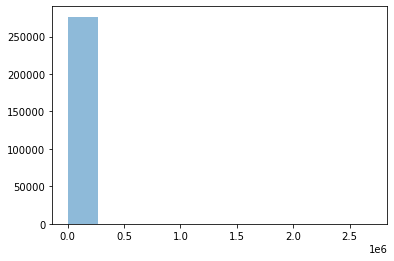

In [33]:
plt.hist(df_impute['price'],alpha=.5);

/var/folders/jn/625fnnbs1jg77y82ld96q65w0000gn/T/ipykernel_1396/342613993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_impute['logged_price']=np.log(df_impute.price)


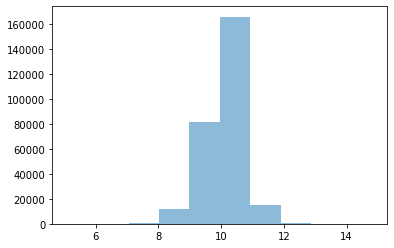

In [34]:
# Try log transform of response variable : 
df_impute['logged_price']=np.log(df_impute.price)
plt.hist(df_impute['logged_price'],alpha=.5);

In [35]:
## improvement *!* 
lm4 = smf.ols('logged_price~city_fuel_economy+daysonmarket+engine_displacement+franchise_dealer+highway_fuel_economy+horsepower+is_new+latitude+longitude+mileage+owner_count+savings_amount+seller_rating', data=df_impute)

# Fit the model
fit4 = lm4.fit()

# Print summary statistics of the model's performance
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           logged_price   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                 1.037e+05
Date:                Sat, 11 Jun 2022   Prob (F-statistic):               0.00
Time:                        08:14:15   Log-Likelihood:                 697.40
No. Observations:              276537   AIC:                            -1367.
Df Residuals:                  276523   BIC:                            -1219.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    9.3627      0.008   1160.677      0.000       9.347       9.378
franchise_dealer[T.True]     0.1031      0.001     72.556      0.000       0.100       0.106
is_new[T.True]               0.1548      0.002    102.073      0.000       0.152       0.158
city_fuel_economy            0.0205      0.000    113.761      0.000       0.020       0.021
daysonmarket              -6.94e-05   4.43e-06    -15.675      0.000   -7.81e-05   -6.07e-05
engine_displacement       -6.55e-05   7.19e-07    -91.139      0.000   -6.69e-05   -6.41e-05
highway_fuel_economy        -0.0228      0.000   -119.529      0.000      -0.023      -0.022
horsepower                   0.0042   1.03e-05    401.674      0.000       0.004       0.004
latitude                     0.0013   9.46e-05     14.120      0.000       0.001       0.002
longitude                   -0.0006   3.37e-05    -18.888      0.000      -0.001      -0.001
mileage                  -7.231e-06    1.7e-08   -425.295      0.000   -7.26e-06    -7.2e-06
owner_count                 -0.0716      0.001    -84.856      0.000      -0.073      -0.070
savings_amount            3.907e-05   5.35e-07     73.073      0.000     3.8e-05    4.01e-05
seller_rating                0.0422      0.001     46.779      0.000       0.040       0.044
==============================================================================
Omnibus:                    53202.773   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1559048.285
Skew:                           0.157   Prob(JB):                         0.00
Kurtosis:                      14.628   Cond. No.                     9.31e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.31e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
# OPEN : Fix this plot

/var/folders/jn/625fnnbs1jg77y82ld96q65w0000gn/T/ipykernel_1396/867911118.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=df_impute.drop((['price','logged_price']),1)


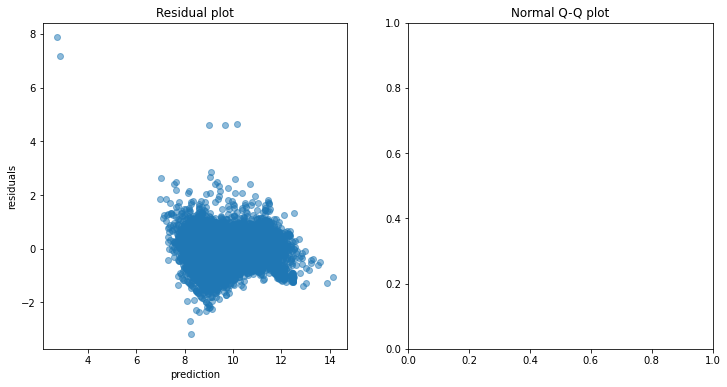

In [37]:
y=df_impute.logged_price
X=df_impute.drop((['price','logged_price']),1)
diagnostic_plot(X,y,fit4)

In [38]:
### Look directly at outliers
res=fit4.resid

df_impute.iloc[np.argsort(res)[-5:]]

,price,savings_amount,seller_rating,year,city_fuel_economy,daysonmarket,engine_displacement,franchise_dealer,highway_fuel_economy,horsepower,is_new,latitude,longitude,mileage,owner_count,logged_price
243564,799900.0,0,3.421053,2007,23.0,45,2500.0,False,32.0,175.0,False,37.6537,-120.9940,120838.0,1.000000,13.592242
92352,1599500.0,0,5.000000,2017,17.0,46,3600.0,False,25.0,283.0,False,36.2035,-94.1381,81992.0,2.000000,14.285202
213402,2698500.0,0,4.714286,2018,17.0,7,3500.0,True,23.0,280.0,False,43.8119,-70.1562,39060.0,1.000000,14.808207
241269,22907.0,0,3.500000,2020,25.0,114,2000.0,True,32.0,161.0,True,35.2449,-114.0380,999999.0,1.532881,10.039198
206028,39523.0,0,3.818182,2020,16.0,63,5300.0,True,22.0,355.0,True,43.6195,-116.3340,1111111.0,1.532881,10.584638


In [39]:
df_impute.sort_values(by='price').tail()

,price,savings_amount,seller_rating,year,city_fuel_economy,daysonmarket,engine_displacement,franchise_dealer,highway_fuel_economy,horsepower,is_new,latitude,longitude,mileage,owner_count,logged_price
234254,626340.0,0,3.600000,2020,12.0,71,3500.0,True,18.0,660.0,True,43.0979,-73.7497,16.0,1.532881,13.347649
243564,799900.0,0,3.421053,2007,23.0,45,2500.0,False,32.0,175.0,False,37.6537,-120.9940,120838.0,1.000000,13.592242
285643,999900.0,0,5.000000,2019,14.0,100,4000.0,False,18.0,789.0,False,34.2129,-118.4660,575.0,1.000000,13.815411
92352,1599500.0,0,5.000000,2017,17.0,46,3600.0,False,25.0,283.0,False,36.2035,-94.1381,81992.0,2.000000,14.285202
213402,2698500.0,0,4.714286,2018,17.0,7,3500.0,True,23.0,280.0,False,43.8119,-70.1562,39060.0,1.000000,14.808207


In [40]:
df_impute=df_impute.drop([213402,92352])

In [41]:
## improvement *!* 
lm5 = smf.ols('logged_price~city_fuel_economy+daysonmarket+engine_displacement+franchise_dealer+highway_fuel_economy+horsepower+is_new+latitude+longitude+mileage+owner_count+savings_amount+seller_rating', data=df_impute)

# Fit the model
fit5 = lm5.fit()

# Print summary statistics of the model's performance
fit5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           logged_price   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                 1.039e+05
Date:                Sat, 11 Jun 2022   Prob (F-statistic):               0.00
Time:                        08:14:16   Log-Likelihood:                 1065.2
No. Observations:              276535   AIC:                            -2102.
Df Residuals:                  276521   BIC:                            -1955.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    9.3627      0.008   1162.220      0.000       9.347       9.378
franchise_dealer[T.True]     0.1032      0.001     72.686      0.000       0.100       0.106
is_new[T.True]               0.1549      0.002    102.275      0.000       0.152       0.158
city_fuel_economy            0.0205      0.000    113.915      0.000       0.020       0.021
daysonmarket              -6.93e-05   4.42e-06    -15.674      0.000    -7.8e-05   -6.06e-05
engine_displacement      -6.551e-05   7.18e-07    -91.263      0.000   -6.69e-05   -6.41e-05
highway_fuel_economy        -0.0228      0.000   -119.671      0.000      -0.023      -0.022
horsepower                   0.0042   1.03e-05    402.207      0.000       0.004       0.004
latitude                     0.0013   9.45e-05     14.115      0.000       0.001       0.002
longitude                   -0.0006   3.37e-05    -18.948      0.000      -0.001      -0.001
mileage                  -7.231e-06    1.7e-08   -425.846      0.000   -7.26e-06    -7.2e-06
owner_count                 -0.0716      0.001    -84.958      0.000      -0.073      -0.070
savings_amount            3.912e-05   5.34e-07     73.261      0.000    3.81e-05    4.02e-05
seller_rating                0.0422      0.001     46.767      0.000       0.040       0.044
==============================================================================
Omnibus:                    50374.120   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1324277.849
Skew:                           0.107   Prob(JB):                         0.00
Kurtosis:                      13.719   Cond. No.                     9.31e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.31e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### #7   Final Check  :Linear Regression Assumptions  




In [42]:
# OPEN  : Bring this down, 

### Step #7   Bring in Categorical variables

In [43]:
## Let's start off by only using numerical vals 
cat_cols=df.dtypes[df.dtypes=='object'].index
df_cat=df[cat_cols]

for i in df_cat.columns:
    print(i)

vin
back_legroom
bed
bed_height
bed_length
body_type
cabin
city
dealer_zip
description
engine_cylinders
engine_type
exterior_color
fleet
frame_damaged
franchise_make
front_legroom
fuel_tank_volume
fuel_type
has_accidents
height
interior_color
isCab
is_cpo
is_oemcpo
length
listed_date
listing_color
main_picture_url
major_options
make_name
maximum_seating
model_name
power
salvage
sp_name
theft_title
torque
transmission
transmission_display
trimId
trim_name
wheel_system
wheel_system_display
wheelbase
width


In [44]:
df.dealer_zip.value_counts()

77477    417
77477    337
77074    298
77034    298
33619    289
        ... 
2554       1
47970      1
79701      1
71112      1
15215      1
Name: dealer_zip, Length: 14316, dtype: int64

In [45]:
def normalize_torque(x):
    try:
        lb_ft=int(x.split()[0])
        rpm=int(x.split()[3].replace(',',''))
        return lb_ft/rpm
    except:
        return np.nan
    

In [46]:
df_impute=df_impute.join(df['torque'])

In [47]:
df_impute['torque_norm']=df_impute['torque'].apply(normalize_torque)
df_impute['torque_norm']=df_impute['torque_norm'].fillna(df_impute['torque_norm'].median())

In [48]:
lm6 = smf.ols('logged_price~torque_norm+city_fuel_economy+daysonmarket+engine_displacement+franchise_dealer+highway_fuel_economy+horsepower+is_new+latitude+longitude+mileage+owner_count+savings_amount+seller_rating', data=df_impute)

# Fit the model
fit6 = lm6.fit()

# Print summary statistics of the model's performance
fit6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           logged_price   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                 9.670e+04
Date:                Sat, 11 Jun 2022   Prob (F-statistic):               0.00
Time:                        08:14:17   Log-Likelihood:                 1280.4
No. Observations:              276535   AIC:                            -2531.
Df Residuals:                  276520   BIC:                            -2373.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    9.3416      0.008   1151.388      0.000       9.326       9.357
franchise_dealer[T.True]     0.1032      0.001     72.755      0.000       0.100       0.106
is_new[T.True]               0.1546      0.002    102.154      0.000       0.152       0.158
torque_norm                  0.0941      0.005     20.757      0.000       0.085       0.103
city_fuel_economy            0.0202      0.000    112.166      0.000       0.020       0.021
daysonmarket             -7.266e-05   4.42e-06    -16.435      0.000   -8.13e-05    -6.4e-05
engine_displacement      -6.248e-05   7.32e-07    -85.367      0.000   -6.39e-05    -6.1e-05
highway_fuel_economy        -0.0223      0.000   -115.458      0.000      -0.023      -0.022
horsepower                   0.0041   1.04e-05    396.927      0.000       0.004       0.004
latitude                     0.0013   9.44e-05     14.282      0.000       0.001       0.002
longitude                   -0.0006   3.37e-05    -19.076      0.000      -0.001      -0.001
mileage                  -7.217e-06    1.7e-08   -425.026      0.000   -7.25e-06   -7.18e-06
owner_count                 -0.0717      0.001    -85.130      0.000      -0.073      -0.070
savings_amount            3.891e-05   5.34e-07     72.905      0.000    3.79e-05       4e-05
seller_rating                0.0418      0.001     46.383      0.000       0.040       0.044
==============================================================================
Omnibus:                    50219.859   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1316262.857
Skew:                           0.099   Prob(JB):                         0.00
Kurtosis:                      13.686   Cond. No.                     9.42e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.42e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
cat_cols=df.dtypes[df.dtypes=='object'].index
df_cat=df[cat_cols]

for i in df_cat.columns:
    print(i)

vin
back_legroom
bed
bed_height
bed_length
body_type
cabin
city
dealer_zip
description
engine_cylinders
engine_type
exterior_color
fleet
frame_damaged
franchise_make
front_legroom
fuel_tank_volume
fuel_type
has_accidents
height
interior_color
isCab
is_cpo
is_oemcpo
length
listed_date
listing_color
main_picture_url
major_options
make_name
maximum_seating
model_name
power
salvage
sp_name
theft_title
torque
transmission
transmission_display
trimId
trim_name
wheel_system
wheel_system_display
wheelbase
width


In [50]:
df_comb=df_impute.join(df[['make_name','maximum_seating']])

In [51]:
df_comb.maximum_seating.value_counts(dropna=False)

5 seats     181415
7 seats      29763
6 seats      23549
8 seats      19769
NaN           8085
4 seats       7910
2 seats       3282
3 seats       1836
15 seats       468
9 seats        313
10 seats        50
--              49
12 seats        46
Name: maximum_seating, dtype: int64

In [52]:
df_comb.maximum_seating=df_comb.maximum_seating.replace('--',None)
df_comb.maximum_seating=df_comb.maximum_seating.fillna('5 seats')

df_comb.maximum_seating=df_comb.maximum_seating.apply(lambda x: x.split()[0]).astype(int)

In [53]:
sorted(df_comb['make_name'].unique())[:5]

['Acura', 'Alfa Romeo', 'Aston Martin', 'Audi', 'BMW']

In [54]:
df_make_dummies=pd.get_dummies(df_comb.make_name,drop_first=True)
df_make_dummies.head()

,Alfa Romeo,Aston Martin,Audi,BMW,Bentley,Buick,Cadillac,Chevrolet,Chrysler,Dodge,FIAT,Ferrari,Fisker,Ford,GMC,Genesis,Honda,Hummer,Hyundai,INFINITI,Isuzu,Jaguar,Jeep,Karma,Kia,Lamborghini,Land Rover,Lexus,Lincoln,Lotus,MINI,Maserati,Maybach,Mazda,McLaren,Mercedes-Benz,Mercury,Mitsubishi,Nissan,Oldsmobile,Plymouth,Pontiac,Porsche,RAM,Rolls-Royce,SRT,Saab,Saturn,Scion,Subaru,Suzuki,Toyota,Volkswagen,Volvo,smart
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [55]:
# Testing with Dummy Make variable!  -- > .831
lm7 = smf.ols('logged_price~maximum_seating+torque_norm+city_fuel_economy+daysonmarket+engine_displacement+franchise_dealer+highway_fuel_economy+horsepower+is_new+latitude+longitude+mileage+owner_count+savings_amount+seller_rating', data=df_comb)

# Fit the model
fit7 = lm7.fit()

# Print summary statistics of the model's performance
fit7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           logged_price   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                 9.086e+04
Date:                Sat, 11 Jun 2022   Prob (F-statistic):               0.00
Time:                        08:14:18   Log-Likelihood:                 2052.3
No. Observations:              276535   AIC:                            -4073.
Df Residuals:                  276519   BIC:                            -3904.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    9.2390      0.009   1086.810      0.000       9.222       9.256
franchise_dealer[T.True]     0.1013      0.001     71.589      0.000       0.099       0.104
is_new[T.True]               0.1536      0.002    101.763      0.000       0.151       0.157
maximum_seating              0.0171      0.000     39.343      0.000       0.016       0.018
torque_norm                  0.0999      0.005     22.097      0.000       0.091       0.109
city_fuel_economy            0.0201      0.000    111.707      0.000       0.020       0.020
daysonmarket             -7.068e-05   4.41e-06    -16.032      0.000   -7.93e-05    -6.2e-05
engine_displacement      -6.593e-05   7.35e-07    -89.688      0.000   -6.74e-05   -6.45e-05
highway_fuel_economy        -0.0215      0.000   -111.604      0.000      -0.022      -0.021
horsepower                   0.0041   1.04e-05    397.653      0.000       0.004       0.004
latitude                     0.0014   9.41e-05     14.491      0.000       0.001       0.002
longitude                   -0.0006   3.36e-05    -18.540      0.000      -0.001      -0.001
mileage                  -7.248e-06    1.7e-08   -427.565      0.000   -7.28e-06   -7.21e-06
owner_count                 -0.0686      0.001    -81.281      0.000      -0.070      -0.067
savings_amount            3.997e-05   5.33e-07     75.009      0.000    3.89e-05     4.1e-05
seller_rating                0.0419      0.001     46.667      0.000       0.040       0.044
==============================================================================
Omnibus:                    51515.997   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1399740.122
Skew:                           0.141   Prob(JB):                         0.00
Kurtosis:                      14.018   Cond. No.                     9.89e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.89e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [56]:
# Testing with Dummy Make variable! 
lm8 = smf.ols('logged_price~make_name+maximum_seating+torque_norm+city_fuel_economy+daysonmarket+engine_displacement+franchise_dealer+highway_fuel_economy+horsepower+is_new+latitude+longitude+mileage+owner_count+savings_amount+seller_rating', data=df_comb)

# Fit the model
fit8 = lm8.fit()

# Print summary statistics of the model's performance
fit8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           logged_price   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                 2.558e+04
Date:                Sat, 11 Jun 2022   Prob (F-statistic):               0.00
Time:                        08:14:19   Log-Likelihood:                 34106.
No. Observations:              276535   AIC:                        -6.807e+04
Df Residuals:                  276464   BIC:                        -6.732e+04
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      9.4621      0.009   1075.084      0.000       9.445       9.479
make_name[T.Alfa Romeo]       -0.0108      0.011     -0.984      0.325      -0.032       0.011
make_name[T.Aston Martin]      0.5906      0.028     21.079      0.000       0.536       0.645
make_name[T.Audi]              0.1342      0.005     24.895      0.000       0.124       0.145
make_name[T.BMW]               0.0910      0.005     18.248      0.000       0.081       0.101
make_name[T.Bentley]           0.2844      0.022     12.703      0.000       0.241       0.328
make_name[T.Buick]            -0.1479      0.005    -30.581      0.000      -0.157      -0.138
make_name[T.Cadillac]          0.0300      0.005      5.935      0.000       0.020       0.040
make_name[T.Chevrolet]        -0.1766      0.004    -42.989      0.000      -0.185      -0.169
make_name[T.Chrysler]         -0.2509      0.005    -46.922      0.000      -0.261      -0.240
make_name[T.Dodge]            -0.3361      0.005    -73.923      0.000      -0.345      -0.327
make_name[T.FIAT]             -0.2262      0.014    -15.827      0.000      -0.254      -0.198
make_name[T.Ferrari]           0.5334      0.024     22.629      0.000       0.487       0.580
make_name[T.Fisker]           -0.2033      0.124     -1.644      0.100      -0.446       0.039
make_name[T.Ford]             -0.2136      0.004    -52.698      0.000      -0.222      -0.206
make_name[T.GMC]              -0.1117      0.005    -24.478      0.000      -0.121      -0.103
make_name[T.Genesis]           0.0010      0.012      0.085      0.933      -0.023       0.025
make_name[T.Honda]            -0.0893      0.004    -21.240      0.000      -0.098      -0.081
make_name[T.Hummer]            0.1813      0.042      4.299      0.000       0.099       0.264
make_name[T.Hyundai]          -0.1464      0.004    -33.407      0.000      -0.155      -0.138
make_name[T.INFINITI]         -0.0671      0.006    -11.927      0.000      -0.078      -0.056
make_name[T.Isuzu]            -0.7361      0.062    -11.892      0.000      -0.857      -0.615
make_name[T.Jaguar]            0.1021      0.009     11.827      0.000       0.085       0.119
make_name[T.Jeep]             -0.0600      0.004    -14.017      0.000      -0.068      -0.052
make_name[T.Karma]             0.1702      0.107      1.589      0.112      -0.040       0.380
make_name[T.Kia]              -0.2280      0.004    -51.052      0.000      -0.237      -0.219
make_name[T.Lamborghini]       0.6313      0.042     14.879      0.000       0.548       0.714
make_name[T.Land Rover]        0.1858      0.007     26.783      0.000       0.172       0.199
make_name[T.Lexus]             0.0967      0.005     18.696      0.000       0.087       0.107
make_name[T.Lincoln]          -0.0523      

### Exercise 
Using your domain knowledge of cars, pick the most valuable categorical features to add to the model. Try as many as you think make sense. 

* Iteratively test the categorical features

*Challenge* : create a function to iteratively test the addition of a new categorical variables. 

In [60]:
cats_to_test=['transmission','model_name','engine_type','wheel_system','fuel_type','has_accidents','dealer_zip']

In [62]:
df_comb=df_comb.join(df[cats_to_test])

Index(['price', 'savings_amount', 'seller_rating', 'year', 'city_fuel_economy',
       'daysonmarket', 'engine_displacement', 'franchise_dealer',
       'highway_fuel_economy', 'horsepower', 'is_new', 'latitude', 'longitude',
       'mileage', 'owner_count', 'logged_price', 'torque', 'torque_norm',
       'make_name', 'maximum_seating', 'transmission', 'model_name',
       'engine_type', 'wheel_system', 'fuel_type', 'has_accidents'],
      dtype='object')

In [65]:
# A quick clean of zips . .
#common_zips=df_comb.dealer_zip.value_counts().index[df_comb.dealer_zip.value_counts()>100]
#df_comb['zips_clean']=df_comb.dealer_zip.apply(lambda x:x if x in common_zips else 'Other')

In [66]:
def categorical_n_check(string,column,df):
    model = smf.ols(string, data=df)
    fit = model.fit()
    print(column)
    print(fit.rsquared)
    print(fit.rsquared_adj)
    print('\n')
    return df_comb,fit.rsquared

In [67]:
# before we run zips .. 
df_comb.dealer_zip=df_comb.dealer_zip.astype('str')

In [ ]:
# Warning ( this may take some time to run  )
string='logged_price~make_name+maximum_seating+torque_norm+city_fuel_economy+daysonmarket+engine_displacement+franchise_dealer+highway_fuel_economy+horsepower+is_new+latitude+longitude+mileage+owner_count+savings_amount+seller_rating'
for col in cats_to_test:
    string+='+' + col
    categorical_n_check(string,col,df_comb)

# Regression with sklearn
Statsmodels has decent functionality for linear models, and is great for statistical summaries. But, scikit-learn has more modeling options for all sorts of algorithms as well as data preparation and is growing every day, so we will generally be working with that from here on.

### Regression with sklearn
Before we jump into some of the additional features of sklearn, let's try to repeat what we have so far using sklearn's built in **LinearRegression**.


In [68]:
df_dummies= pd.get_dummies(df_comb[['transmission','model_name','make_name','engine_type','dealer_zip','wheel_system','fuel_type','has_accidents']],drop_first=True)

### combine with the previous
df_cat_num=df_comb.drop(['torque','dealer_zip','transmission','model_name','make_name','engine_type','dealer_zip','wheel_system','fuel_type','has_accidents'],1).join(df_dummies)

/var/folders/jn/625fnnbs1jg77y82ld96q65w0000gn/T/ipykernel_1396/2877109668.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_cat_num=df_comb.drop(['torque','dealer_zip','transmission','model_name','make_name','engine_type','dealer_zip','wheel_system','fuel_type','has_accidents'],1).join(df_dummies)


In [72]:
df_cat_num=df_cat_num.drop('zips_clean',1)

/var/folders/jn/625fnnbs1jg77y82ld96q65w0000gn/T/ipykernel_1396/1020101534.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_cat_num=df_cat_num.drop('zips_clean',1)


In [73]:
X=df_cat_num.drop(['price','logged_price'],1)
y=df_cat_num.logged_price

/var/folders/jn/625fnnbs1jg77y82ld96q65w0000gn/T/ipykernel_1396/3259450904.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=df_cat_num.drop(['price','logged_price'],1)


In [74]:
# Create an empty model
# warning!  may take awhile to run. .  (start_time, 15 mins)
# sklearn : automatially fits intercept
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

# Partition remaining data into train/validation for 60, 20, 20 divide
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 3)

# Fit the model to the full dataset
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train, y_train)

# Print out the R^2 for the model against the full dataset
print('Train R^2: {:6.3f}'.format(lr.score(X_train,y_train)))

# Print out the R^2 for the model against the full dataset
print('Val R^2: {:6.3f}'.format(lr.score(X_val,y_val)))

Train R^2:  0.941
Val R^2:  0.929


### Big Machine Learning Idea #1 :  Cross Validation 

In [79]:
### Feature Interpretation

feat_df=pd.DataFrame({'coef':lr.coef_,'features':X.columns,'abs_val_coef':np.abs(lr.coef_)}).sort_values(by='abs_val_coef')
feat_df.tail(10)

,coef,features,abs_val_coef
51,1.858892,model_name_570S,1.858892
369,1.949879,model_name_GT,1.949879
60,1.979697,model_name_720S,1.979697
45,2.136350,model_name_500-Class,2.136350
439,2.171923,model_name_LFA,2.171923
523,2.417353,model_name_NSX,2.417353
302,2.438492,model_name_EuroVan,2.438492
396,2.555728,model_name_Grand Wagoneer,2.555728
853,2.565048,model_name_Z8,2.565048
7702,2.619997,dealer_zip_89139,2.619997


## sklearn: What's in a model?
Essentially all models in `sklearn` inherit from the same type of "estimator" interface.  This means they'll share common methods that we'll see over and over again like:
- `fit()`: Fit a model to a set of training data
- `score()`: Score the performance of a model on a given sample of data with known _ground truth_ dependent variables
- `predict()`: Predict target/response variables based on a sample of independent variables (features, predictors, etc)

Additionally, models are usually loaded with other goodies once they've been fit, which can provide information about the resulting fitted model.  For instance, the following might be of interest in regression:
- `intercept_`: our $\beta_0$ intercept in our regression model
- `coef_`: the other $\beta$s in our model



##### Pickling for Later
We're going to come back to this dataset!  So let's pickle it away for later...

`sklearn`, `pandas` and `statsmodels` have their own respective methods for "pickling" their objects.

**Pandas:**

To pickle a `pandas.DataFrame` use the [`to_pickle()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_pickle.html) method.  Use this now to pickle your training data `df` now.

In [77]:
# Pickle your pandas dataframe
df_cat_numb.to_pickle('data/df_cat_numb.pkl')

**Statsmodels**

To pickle a statsmodels object us the [`save()`](http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.linear_model.OLSResults.save.html#statsmodels.regression.linear_model.OLSResults.save) method.  Use this to pickle your best fit model `fit2` to `survey_sm_model.pkl` now.

In [163]:
# Pickle fit8 to a file 
fit8.save('models/sm_model_8.pkl')

**sklearn**

Pickle an `sklearn` model to the file `survey_sk_model.pkl` using the `sklearn` replacement for pickle `joblib` as seen [here](http://scikit-learn.org/stable/modules/model_persistence.html).

In [78]:
import joblib
joblib.dump(lr, 'models/sklearn_model_1.pkl')

['models/sklearn_model_1.pkl']

# Polynomial Regression
So far we've only tried to create regression models that are linear functions of the predictor variables.  However, there's no reason we can't transform the predictor variables by any type of function we want before inputting them to linear regression.  This is the idea behind [**Polynomial Regression**](https://en.wikipedia.org/wiki/Polynomial_regression) and it allows us (along with similar functional regressions) to essentially model our response variables as any function of our predictor variables that we like.  Viewed in this way, Linear Regression is just a special instance of Polynomial Regression with a polynomial of degree 1.

## Polynomial Regression with sklearn
sklearn has built-in options for converting your predictor variables to polynomial functions of them.  In this exercise we'll use the [**PolynomialFeatures**](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) class of sklearn to manipulate incoming predictors into nth-order polynomials of those features.  We'll combine this with the [***make_pipeline***](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) function to string together a pipeline of operations that is able to first transform our linear features into polynomial features and then run a linear regression against the resulting polynomial features. 

### Generating Random Data
The first thing we're going to do is manufacture some data from a known distribution with a little additive noise.  This allows us to compare our results to the known ground truth.  Let's create that data from a sine curve as follows:

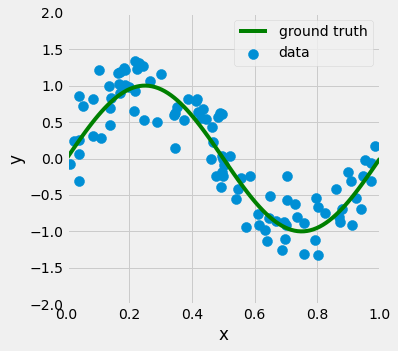

In [165]:
from IPython.core.pylabtools import figsize
figsize(5,5)
plt.style.use('fivethirtyeight')

# We start by seeding the random number generator so that everyone will have the same "random" results
np.random.seed(9)

# Function that returns the sin(2*pi*x)
def f(x):
    return np.sin(2 * np.pi * x)

# generate points used to plot
# This returns 100 evenly spaced numbers from 0 to 1
x_plot = np.linspace(0, 1, 100)

# generate points and keep a subset of them
n_samples = 100
# Generate the x values from the random uniform distribution between 0 and 1
X = np.random.uniform(0, 1, size=n_samples)[:, np.newaxis]
# Generate the y values by taking the sin and adding a random Gaussian (normal) noise term
y = f(X) + np.random.normal(scale=0.3, size=n_samples)[:, np.newaxis]

# Plot the training data against what we know to be the ground truth sin function
fig,ax = plt.subplots(1,1);
ax.plot(x_plot, f(x_plot), label='ground truth', color='green')
ax.scatter(X, y, label='data', s=100)
ax.set_ylim((-2, 2))
ax.set_xlim((0, 1))
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend();

## Fitting an nth-degree Polynomial
Now that we have our data and know the ground truth, let's try fitting a 3rd degree polynomial to our training data and see how it looks.  3rd degree makes sense for this interval because the sin function has 2 turning points over the interval [0,1] and a 3rd degree polynomial will general have 2 (or less) turning points.

We first define a function `plot_approximation` that takes a pipeline of steps from make_pipeline and some plotting info and will plot the results of the sklearn pipeline on the specified plot with the ground truth and data in the background.

In [166]:
# import PolynomialFeatures and make_pipeline for Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Plot the results of a pipeline against ground truth and actual data
def plot_approximation(est, ax, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(x_plot, f(x_plot), label='ground truth', color='green')
    ax.scatter(X, y, s=100)
    ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='upper right',frameon=True)

Now let's generate our pipeline for a 3rd degree polynomial and try it out in our plotting function.  Note that the steps are:
- Use PolynomialFeatures(3) to create a generator of 3rd degree polynomials
- Feed this generator to make_pipeline along with a LinearRegression object to tell it to string together these operations when given a new set of input predictor variables.  This results in a new model object that has the same `fit()`, `score()`, `predict()`, etc functions
- Call `fit()` on our new object to fit a 3rd degree polynomial regression
- Send the result to our plotting function to view the results

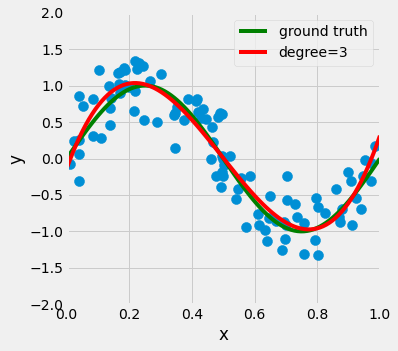

In [167]:
# Set up the plot
fig,ax = plt.subplots(1,1)
# Set the degree of our polynomial
degree = 3

# Generate the model type with make_pipeline
# This tells it the first step is to generate 3rd degree polynomial features in the input features and then run
# a linear regression on the resulting features
est = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Fit our model to the training data
est.fit(X, y)
# Plot the results
plot_approximation(est, ax, label='degree=%d' % degree)

> How would you characterize this fit?

Plot the fit of a polynomial of degree 2:

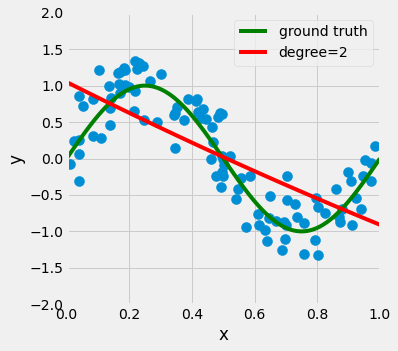

In [168]:
# Set up the plot
fig,ax = plt.subplots(1,1)
# Set the degree of our polynomial
degree = 2
# Generate the model type with make_pipeline
# This tells it the first step is to generate 3rd degree polynomial features in the input features and then run
# a linear regression on the resulting features
est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
# Fit our model to the training data
est.fit(X, y)
# Plot the results
plot_approximation(est, ax, label='degree=%d' % degree)

Plot the fit of a polynomial of degree 9, or heck, how bout 27!?:

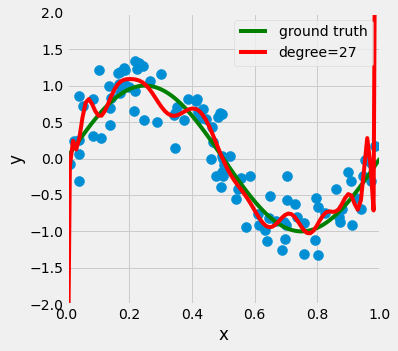

In [169]:
# Set up the plot
fig,ax = plt.subplots(1,1)
# Set the degree of our polynomial
degree = 27
# Generate the model type with make_pipeline
# This tells it the first step is to generate 3rd degree polynomial features in the input features and then run
# a linear regression on the resulting features
est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
# Fit our model to the training data
est.fit(X, y)
# Plot the results
plot_approximation(est, ax, label='degree=%d' % degree)

> What happens as we increase the degree of polynomial?

> Which polynomial should we choose?

To gain some insight into this, let's plot polynomials from degree 1 to 9 and examine how the errors in our predictions change vs. the training and test sets.

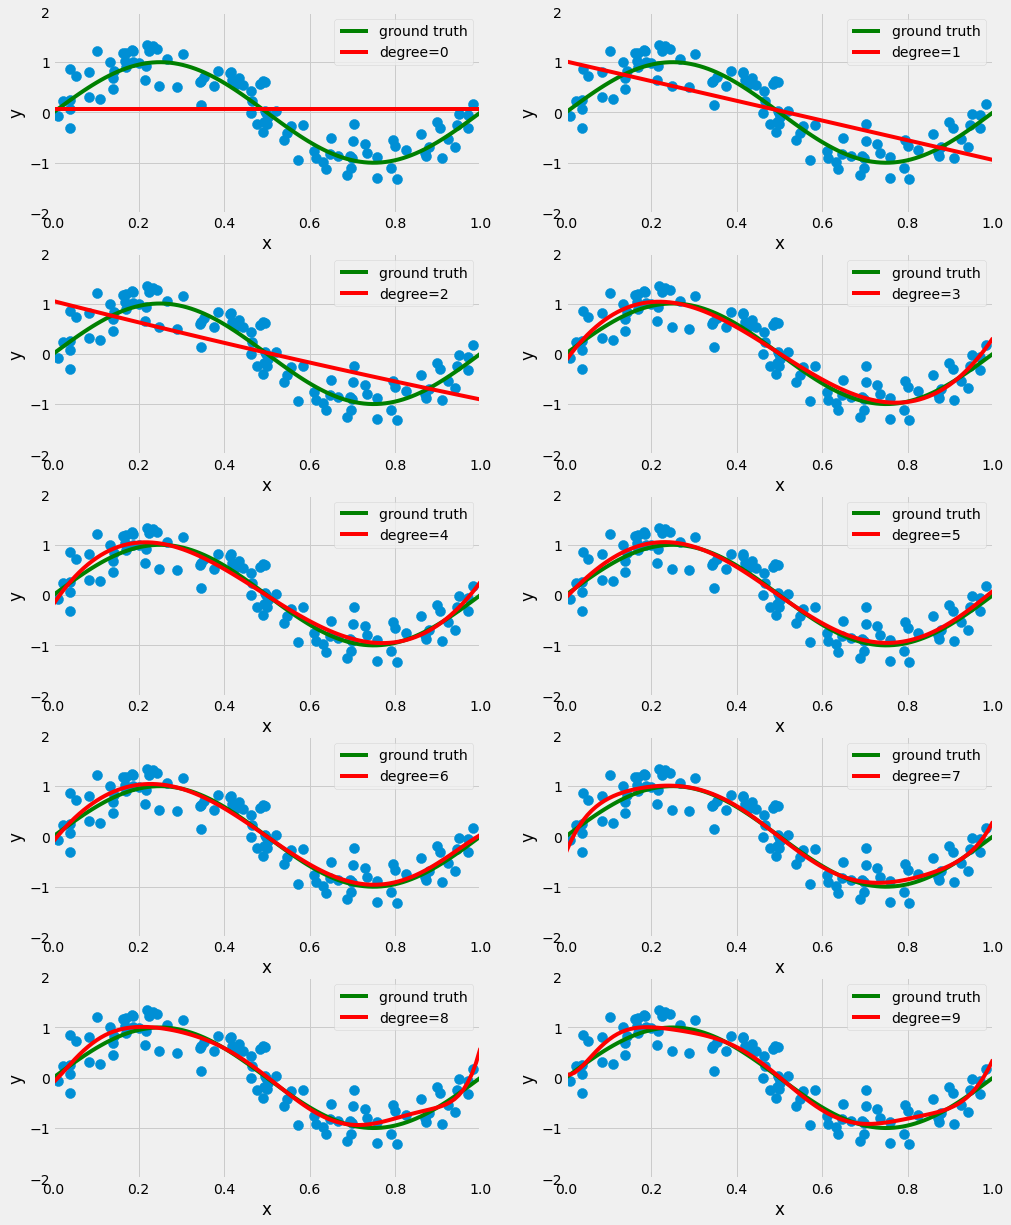

In [170]:
# Step through degrees from 0 to 9 and store the training and test (generalization) error.
# This sets up 5 rows of 2 plots each (KEEP)
fig, ax_rows = plt.subplots(5, 2, figsize=(15, 20))
for degree in range(10):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X, y)
    # This sets the appropriate axis for each degree (KEEP)
    ax_row_left, ax_row_right = ax_rows[degree//2]
    if degree%2 == 0:
        ax = ax_row_left
    else:
        ax = ax_row_right
    plot_approximation(est, ax, label='degree=%d' % degree)

> What do you notice?

### Pickling for later
We may return to this fake data for further exploration later, so let's pickle our `X` and `y` so we can do just that.  To save `numpy` arrays, you use the [`numpy.save()`](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.save.html) method.  We can save multiple arrays to one file with the [`numpy.savez()`](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.savez.html) method.  Use this now to save `X` and `y` to the file `poly_data.npz`.

In [78]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# polyNomial=PolynomialFeatures(interaction_only=True,include_bias=False)
# X_poly=polyNomial.fit_transform(X)
# # Fit our model to the training data

# X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.2, random_state = 10)
# # Partition remaining data into train/validation for 60, 20, 20 divide
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 3)

# lr.fit(X_train, y_train)

In [ ]:
# # Print out the R^2 for the model against the full dataset
# print('Train R^2: {:6.3f}'.format(lr.score(X_train,y_train)))

# # Print out the R^2 for the model against the full dataset
# print('Val R^2: {:6.3f}'.format(lr.score(X_val,y_val)))

In [ ]:
# feat_df=pd.DataFrame({'coef':lr.coef_,'features':X.columns,'abs_val_coef':np.abs(lr.coef_)}).sort_values(by='abs_val_coef')
# feat_df.tail(10)

### Big Machine Learning Idea #2  : Bias Variance Trade-off 

In [81]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
clf = linear_model.Lasso()

# Standardize features

std=StandardScaler()

X_train_std=std.fit_transform(X_train)
X_val_std=std.transform(X_val)

In [82]:
pd.DataFrame(X_train_std).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,8075,8076,8077,8078,8079,8080,8081,8082,8083,8084,8085,8086,8087,8088,8089,8090,8091,8092,8093,8094,8095,8096,8097,8098,8099,8100,8101,8102,8103,8104,8105,8106,8107,8108,8109,8110,8111,8112,8113,8114,8115,8116,8117,8118,8119,8120,8121,8122,8123,8124,8125,8126,8127,8128,8129,8130,8131,8132,8133,8134,8135,8136,8137,8138,8139,8140,8141,8142,8143,8144,8145,8146,8147,8148,8149,8150,8151,8152,8153,8154,8155,8156,8157,8158,8159,8160,8161,8162,8163,8164,8165,8166,8167,8168,8169,8170,8171,8172,8173,8174,8175,8176,8177,8178,8179,8180,8181,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191,8192,8193,8194,8195,8196,8197,8198,8199,8200,8201,8202,8203,8204,8205,8206,8207,8208,8209,8210,8211,8212,8213,8214,8215,8216,8217,8218,8219,8220,8221,8222,8223,8224,8225,8226,8227,8228,8229,8230,8231,8232,8233,8234,8235,8236,8237,8238,8239,8240,8241,8242,8243,8244,8245,8246,8247,8248,8249,8250,8251,8252,8253,8254,8255,8256,8257,8258,8259,8260,8261,8262,8263,8264,8265,8266,8267,8268,8269,8270,8271,8272,8273,8274,8275,8276,8277,8278,8279,8280,8281,8282,8283,8284,8285,8286,8287,8288,8289,8290,8291,8292,8293,8294,8295,8296,8297,8298,8299,8300,8301,8302,8303,8304,8305,8306,8307,8308,8309,8310,8311,8312,8313,8314,8315,8316,8317,8318,8319,8320,8321,8322,8323,8324
count,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,165921.0,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,165921.0,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,165921.0,1.659210e+05,1.659210e+05,1.659210e+05,165921.0,165921.0,1.659210e+05,165921.0,1.659210e+05,1.659210e+05,165921.0,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,165921.0,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,165921.0,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,165921.0,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.659210e+05,1.65

In [83]:
alpha_list=np.logspace(-4,4,10)
alpha_list

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [ ]:
train_scores=[]
val_scores=[]
for a in alpha_list:
    # update alpha value! 
    clf = linear_model.Lasso(alpha=a)
    clf.fit(X_train_std,y_train)
    train_scores.append(clf.score(X_train_std,y_train))
    val_scores.append(clf.score(X_val_std,y_val))

In [ ]:
plt.plot(train_scores,alpha=.5,label='train')
plt.plot(val_scores,alpha=.5,label='validation')
plt.legend();

In [ ]:
alpha_list[np.argmax(val_scores)]

In [ ]:
## Create final 

### Big Machine Learning Idea #3, Model Optimization 

In [ ]:
### On your Own : 




## What have we done?
- Learned how to use statsmodels with R formula syntax for creating linear models
- Learned how to evaluate models using adjusted R^2
- Understood linear and polynomial regression in sklearn
- Used seaborn for visualizing relationships in data
- Used pandas for manipulating data as we move through our workflow
- Gotten a peak into a genuine data science workflow
- Seen how curiosity and creativity can yield big gains in a data science modeling pipeline



In [ ]:
archives 

df_impute['highway_fuel_economy']=df_impute[["highway_fuel_economy","engien"]].groupby("bedrooms").transform(lambda x: x.fillna(x.median()))